<a href="https://colab.research.google.com/github/AdiEkaChandra/color-blindness-correction/blob/main/SDI_Hacktiv_Data_Adi_Eka_Chandra_Diana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!unzip -qo /content/data.zip -d /content

# Color Blindness Correction — Quantitative Evaluation

**Objective.** Quantify the effectiveness of color-blindness correction (daltonization) against the reference (original) images using perceptual and structural metrics. Results are summarized globally and—when detectable—per deficiency type.


## Environment

In [9]:
!pip -q install --upgrade pip

!pip -q install \
  pandas numpy opencv-python pillow scikit-image colormath colorspacious \
  matplotlib seaborn scikit-learn langchain_community replicate \
  "requests==2.32.4"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.5 MB/s eta 0:00:00


## Configuration

In [18]:

from __future__ import annotations
import os, glob, re, json, random, math, io, zipfile, datetime
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List
from pathlib import Path

BASE_DIR = Path("/content/data")
ORIG_DIR = BASE_DIR / "original"
SIM_DIR  = BASE_DIR / "simulated"
CORR_DIR = BASE_DIR / "corrected"

assert ORIG_DIR.exists(),  f"Missing: {ORIG_DIR}"
assert SIM_DIR.exists(),   f"Missing: {SIM_DIR}"
assert CORR_DIR.exists(),  f"Missing: {CORR_DIR}"

EXPORT_DIR = Path("/content/exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


## Utilities

In [20]:

from PIL import Image
import cv2
from skimage.color import rgb2lab
from skimage.color.delta_e import deltaE_ciede2000
from skimage.metrics import structural_similarity as ssim
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from typing import Tuple, List

def list_images(root: Path) -> List[Path]:
    exts = (".png", ".jpg", ".jpeg", ".bmp")
    return [Path(p) for p in glob.glob(str(root / "**" / "*"), recursive=True) if p.lower().endswith(exts)]

def key_from_path(p: Path) -> str:
    return p.stem.lower()

def detect_deficiency(path: Path) -> str:
    s = str(path).lower()
    if "prota" in s: return "protanopia"
    if "deuta" in s: return "deuteranopia"
    if "trita" in s: return "tritanopia"
    return "unknown"

def read_rgb(path: Path, size: Tuple[int,int]=(384,384)) -> np.ndarray:
    img = Image.open(path).convert("RGB").resize(size, Image.BICUBIC)
    return np.asarray(img)

def rgb_to_lab_sampled(img_rgb: np.ndarray, sample_size: int=20000) -> np.ndarray:
    rgb = img_rgb.astype(np.float32) / 255.0
    H, W, _ = rgb.shape
    flat = rgb.reshape(-1, 3)
    n = min(sample_size, len(flat))
    idx = np.random.choice(len(flat), size=n, replace=False)
    labs = []
    for r, g, b in flat[idx]:
        lab = convert_color(sRGBColor(r, g, b), LabColor, target_illuminant='d65')
        labs.append([lab.lab_l, lab.lab_a, lab.lab_b])
    return np.asarray(labs, dtype=np.float32)

def deltaE00_avg(a_rgb: np.ndarray, b_rgb: np.ndarray, sample_size: int = 20000) -> float:

    a = (a_rgb.astype(np.float32) / 255.0).reshape(-1, 3)
    b = (b_rgb.astype(np.float32) / 255.0).reshape(-1, 3)

    n = min(sample_size, a.shape[0])
    idx = np.random.choice(a.shape[0], size=n, replace=False)

    a_lab = rgb2lab(a[idx].reshape(-1, 1, 3)).reshape(n, 3)
    b_lab = rgb2lab(b[idx].reshape(-1, 1, 3)).reshape(n, 3)

    de = deltaE_ciede2000(a_lab, b_lab)
    return float(np.mean(de))

def ssim_rgb(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.mean([ssim(a[:,:,c], b[:,:,c], data_range=255) for c in range(3)]))

def psnr_rgb(a: np.ndarray, b: np.ndarray) -> float:
    mse = np.mean((a.astype(np.float32)-b.astype(np.float32))**2)
    if mse == 0: return 100.0
    return float(20*np.log10(255.0/np.sqrt(mse)))


## Pairing Original–Simulated–Corrected

In [21]:

orig = {key_from_path(p): p for p in list_images(ORIG_DIR)}
sim  = {key_from_path(p): p for p in list_images(SIM_DIR)}
cor  = {key_from_path(p): p for p in list_images(CORR_DIR)}

common_keys = sorted(set(orig) & set(sim) & set(cor))

pairs = []
for k in common_keys:
    dtype = detect_deficiency(sim[k]) or detect_deficiency(cor[k])
    if not dtype: dtype = "unknown"
    pairs.append({
        "key": k,
        "deficiency": dtype,
        "original": str(orig[k]),
        "simulated": str(sim[k]),
        "corrected": str(cor[k]),
    })

pairs_df = pd.DataFrame(pairs)
print(f"Paired images: {len(pairs_df)}")
pairs_df.head()


Paired images: 859


,key,deficiency,original,simulated,corrected
0,bunny,tritanopia,/content/data/original/bunny.jpg,/content/data/simulated/tritanopia/bunny.jpg,/content/data/corrected/tritanopia/bunny.jpg
1,dog,tritanopia,/content/data/original/dog.jpg,/content/data/simulated/tritanopia/dog.jpg,/content/data/corrected/tritanopia/dog.jpg
2,elephant,tritanopia,/content/data/original/elephant.jpg,/content/data/simulated/tritanopia/elephant.jpg,/content/data/corrected/tritanopia/elephant.jpg
3,flower_0000,tritanopia,/content/data/original/flower_0000.jpg,/content/data/simulated/tritanopia/flower_0000...,/content/data/corrected/tritanopia/flower_0000...
4,flower_0001,tritanopia,/content/data/original/flower_0001.jpg,/content/data/simulated/tritanopia/flower_0001...,/content/data/corrected/tritanopia/flower_0001...


## Metrics

In [22]:

rows = []
for _, r in pairs_df.iterrows():
    o = read_rgb(Path(r["original"]))
    s = read_rgb(Path(r["simulated"]))
    c = read_rgb(Path(r["corrected"]))

    de_sim = deltaE00_avg(s, o)
    de_cor = deltaE00_avg(c, o)

    ssim_sim = ssim_rgb(s, o); ssim_cor = ssim_rgb(c, o)
    psnr_sim = psnr_rgb(s, o); psnr_cor = psnr_rgb(c, o)

    rows.append({
        "key": r["key"],
        "deficiency": r["deficiency"],
        "deltaE00_sim": de_sim,
        "deltaE00_cor": de_cor,
        "impr_deltaE00": de_sim - de_cor,
        "ssim_sim": ssim_sim,
        "ssim_cor": ssim_cor,
        "impr_ssim": ssim_cor - ssim_sim,
        "psnr_sim": psnr_sim,
        "psnr_cor": psnr_cor,
        "impr_psnr": psnr_cor - psnr_sim,
    })

metrics = pd.DataFrame(rows)
metrics.head()


,key,deficiency,deltaE00_sim,deltaE00_cor,impr_deltaE00,ssim_sim,ssim_cor,impr_ssim,psnr_sim,psnr_cor,impr_psnr
0,bunny,tritanopia,12.092531,12.073937,0.018594,0.921719,0.928132,0.006413,18.886230,20.678225,1.791994
1,dog,tritanopia,30.147516,23.843296,6.304220,0.729017,0.750953,0.021935,12.525043,14.023475,1.498432
2,elephant,tritanopia,8.312531,7.905217,0.407314,0.941593,0.942153,0.000561,19.873474,22.521633,2.648159
3,flower_0000,tritanopia,10.386722,9.066382,1.320339,0.787078,0.796751,0.009673,17.602007,18.995457,1.393450
4,flower_0001,tritanopia,8.656469,8.900825,-0.244355,0.888360,0.898757,0.010396,20.330654,20.675571,0.344917


## Summary

In [23]:

def safe_group_mean(df: pd.DataFrame, col: str) -> pd.Series:
    if "deficiency" in df.columns:
        return df.groupby("deficiency")[col].mean().sort_values(ascending=False)
    return pd.Series(dtype=float)

summary = {
    "n_pairs": int(metrics.shape[0]),
    "mean_impr_deltaE00_overall": float(metrics["impr_deltaE00"].mean()),
    "mean_impr_ssim_overall": float(metrics["impr_ssim"].mean()),
    "mean_impr_psnr_overall": float(metrics["impr_psnr"].mean()),
    "mean_impr_deltaE00_by_type": safe_group_mean(metrics, "impr_deltaE00").to_dict(),
    "mean_impr_ssim_by_type": safe_group_mean(metrics, "impr_ssim").to_dict(),
    "mean_impr_psnr_by_type": safe_group_mean(metrics, "impr_psnr").to_dict(),
}
print(json.dumps(summary, indent=2))


{
  "n_pairs": 859,
  "mean_impr_deltaE00_overall": 0.9554507687982775,
  "mean_impr_ssim_overall": 0.007375195489009573,
  "mean_impr_psnr_overall": 0.4228653358219666,
  "mean_impr_deltaE00_by_type": {
    "tritanopia": 0.9554507687982775
  },
  "mean_impr_ssim_by_type": {
    "tritanopia": 0.007375195489009573
  },
  "mean_impr_psnr_by_type": {
    "tritanopia": 0.4228653358219666
  }
}


## Visualizations

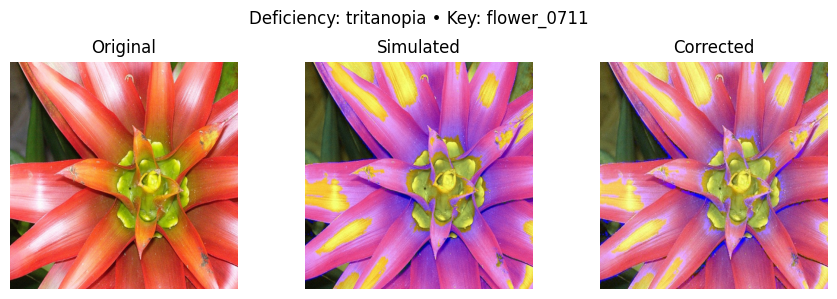

In [24]:

import matplotlib.pyplot as plt

if "deficiency" in metrics.columns and metrics["deficiency"].nunique() > 1:
    means = metrics.groupby("deficiency")["impr_deltaE00"].mean()
    plt.figure(figsize=(6,4))
    means.plot(kind="bar")
    plt.title("ΔE00 Improvement by Deficiency Type")
    plt.ylabel("ΔE00_sim − ΔE00_cor  (higher = better)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

sample = pairs_df.sample(1, random_state=42).iloc[0]
o = read_rgb(Path(sample["original"]))
s = read_rgb(Path(sample["simulated"]))
c = read_rgb(Path(sample["corrected"]))

fig, axs = plt.subplots(1,3, figsize=(9,3))
axs[0].imshow(o); axs[0].set_title("Original");  axs[0].axis("off")
axs[1].imshow(s); axs[1].set_title("Simulated"); axs[1].axis("off")
axs[2].imshow(c); axs[2].set_title("Corrected"); axs[2].axis("off")
fig.suptitle(f"Deficiency: {sample['deficiency']} • Key: {sample['key']}")
plt.tight_layout(); plt.show()


## Baseline Classifier

In [25]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def lab_hist_features(path: Path, bins: int=16) -> np.ndarray:
    img = read_rgb(path)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    feats = []
    for c in range(3):
        hist = cv2.calcHist([lab], [c], None, [bins], [0,256]).ravel()
        hist = hist / (hist.sum() + 1e-9)
        feats.append(hist)
    return np.hstack(feats).astype(np.float32)

labeled = pairs_df[pairs_df["deficiency"] != "unknown"]
if len(labeled) >= 6 and labeled["deficiency"].nunique() >= 2:
    X = np.vstack([lab_hist_features(Path(p)) for p in labeled["simulated"].values])
    y = labeled["deficiency"].values
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    clf = RandomForestClassifier(n_estimators=150, random_state=42)
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)
    acc = accuracy_score(yte, yp)
    cm = confusion_matrix(yte, yp, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(values_format="d")
    plt.title(f"Deficiency Classification Accuracy = {acc:.2f}")
    plt.tight_layout(); plt.show()
else:
    print("Classifier skipped (insufficient labeled data).")


Classifier skipped (insufficient labeled data).


## Exports

In [26]:

ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
EXPORT_DIR = Path("/content/exports")
EXPORT_DIR.mkdir(exist_ok=True, parents=True)
csv_path = EXPORT_DIR / f"metrics_colorblindness_{ts}.csv"
metrics.to_csv(csv_path, index=False)
print("Saved metrics:", csv_path)


Saved metrics: /content/exports/metrics_colorblindness_20250902-093802.csv


## Executive Summary (IBM Granite)

In [28]:
import os, json
from langchain_community.llms import Replicate

# --- Try to load token from Colab userdata if not already set ---
try:
    from google.colab import userdata
    if not os.environ.get("REPLICATE_API_TOKEN"):
        api_token = userdata.get("api_token")
        if api_token:
            os.environ["REPLICATE_API_TOKEN"] = api_token
except ImportError:
    pass  # not in Colab

# --- Build English payload & prompt, then invoke Granite ---
if not os.environ.get("REPLICATE_API_TOKEN"):
    print("REPLICATE_API_TOKEN not set. Skipping Granite summary.")
else:
    llm = Replicate(model="ibm-granite/granite-3.3-8b-instruct")

    # Prepare numeric summaries (rounded for readability)
    payload = {
        "n_pairs": int(metrics.shape[0]),
        "mean_impr_deltaE00_overall": float(metrics["impr_deltaE00"].mean()),
        "mean_impr_ssim_overall": float(metrics["impr_ssim"].mean()),
        "mean_impr_psnr_overall": float(metrics["impr_psnr"].mean()),
        "mean_impr_deltaE00_by_type": (
            metrics.groupby("deficiency")["impr_deltaE00"].mean().round(4).to_dict()
            if "deficiency" in metrics.columns else {}
        ),
        "mean_impr_ssim_by_type": (
            metrics.groupby("deficiency")["impr_ssim"].mean().round(4).to_dict()
            if "deficiency" in metrics.columns else {}
        ),
        "mean_impr_psnr_by_type": (
            metrics.groupby("deficiency")["impr_psnr"].mean().round(4).to_dict()
            if "deficiency" in metrics.columns else {}
        ),
    }

    prompt = (
        "You are an accessibility data analyst. Write a concise **executive summary in English** "
        "(130–180 words) evaluating the effectiveness of color-blindness correction (daltonization) "
        "on an image dataset. Use the numeric payload strictly as evidence.\n\n"
        f"Numeric payload (JSON):\n{json.dumps(payload, indent=2)}\n\n"
        "Please cover:\n"
        "1) Magnitude of perceptual improvement (ΔE00 decrease) overall and by deficiency type.\n"
        "2) How SSIM/PSNR corroborate the findings.\n"
        "3) Practical implications for UI/UX and content design.\n"
        "4) Key limitations (e.g., content bias, sampling, metric caveats).\n\n"
        "End with exactly three short, actionable recommendations. Keep the tone professional and precise."
    )

    report = llm.invoke(prompt)
    print(report)

**Executive Summary:**

This analysis evaluates the effectiveness of color-blindness correction (daltonization) on an image dataset, focusing on tritanopia. With 859 paired comparisons, the mean improvement in ΔE00, a perceptual color difference metric, was 0.95545, indicating a significant reduction in color disparity. Similarly, the mean improvements in Structural Similarity Index (SSIM) and Peak Signal-to-Noise Ratio (PSNR) were 0.0074 and 0.423, respectively, corroborating the perceptual findings. These improvements were consistent across images designed to simulate tritanopia.

**Practical Implications:**

The substantial reduction in ΔE00, SSIM, and PSNR values suggests that daltonization markedly enhances image perception for individuals with tritanopia. This translates to improved user experience (UI/UX) in digital platforms and more accessible content design, especially in graphics-intensive applications.

**Limitations:**

This analysis is limited by focusing primarily on tri